In [2]:
import numpy as numpy
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import random
import os
from pymol import cmd
from collections import defaultdict, Counter 


In [3]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]

In [4]:
# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]

In [5]:
combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

In [6]:
shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

In [7]:
l = ['CTLA-4', 'TIM3', 'PD-1', 'PD-L1', 'KIR', 'LAG3']

cp_cout_df = pd.DataFrame(index = l)

for item in l:
    count = shuffled_df[shuffled_df['compound'].str.contains(item, na=False)].shape[0]
    cp_cout_df.loc[item, 'count'] = count

cp_cout_df = cp_cout_df.reset_index()
cp_cout_df.columns = ['checkpoint', 'count'] 

In [8]:
# 1. Filter all relevant rows: those with 'mab' OR 'M6903'
ab_mask = shuffled_df['compound'].str.contains('mab|M6903', na=False, case=False)
shuffled_df_ab = shuffled_df[ab_mask]

# 2. Extract antibody names
shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)

# 3. Fill in M6903 manually where missing
m6903_mask = shuffled_df_ab['compound'].str.contains('M6903', na=False)
shuffled_df_ab.loc[m6903_mask, 'antibody'] = shuffled_df_ab.loc[m6903_mask, 'antibody'].fillna('M6903')

# # 4. Extract checkpoint names
checkpoints_pattern = r'\b(PD-1|PD-L1|CTLA-4|KIR2DL3|TIM3)\b'
shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)

# # 5. Final formatting
shuffled_df_ab = shuffled_df_ab[['antibody', 'checkpoint', 'pdb', 'Hchain', 'Lchain', 'antigen_chain']]
shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

shuffled_df_ab

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23772/60524799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)
/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23772/60524799.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)


,antibody,checkpoint,pdb,Hchain,Lchain,antigen_chain
0,PEMBROLIZUMAB,PD-1,5b8c,K,J,L
3,ATEZOLIZUMAB,PD-L1,5xxy,H,L,A
4,ATEZOLIZUMAB,PD-L1,5x8l,F,K,A
5,IPILIMUMAB,CTLA-4,7su1,H,L,C
6,IPILIMUMAB,CTLA-4,7su0,H,L,C
8,NIVOLUMAB,PD-1,5ggr,A,B,Y
9,PEMBROLIZUMAB,PD-1,5b8c,E,D,F
11,TISLELIZUMAB,PD-1,7cgw,H,L,P
12,IPILIMUMAB,CTLA-4,5tru,h,l,c
13,PEMBROLIZUMAB,PD-1,5jxe,D,C,B


In [9]:
pdb_list = shuffled_df_ab['pdb'].unique().tolist()
#shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

with open('pdb_list.txt', 'w') as f:
    for pdb in pdb_list:
        f.write(pdb + '\n')

In [10]:
# make a list of the columns 
shuffled_df_ab = shuffled_df_ab[['pdb', 'Hchain', 'Lchain', 'antigen_chain']]
extracted_list = shuffled_df_ab.values.tolist()

extracted_list


[['5b8c', 'K', 'J', 'L'],
 ['5xxy', 'H', 'L', 'A'],
 ['5x8l', 'F', 'K', 'A'],
 ['7su1', 'H', 'L', 'C'],
 ['7su0', 'H', 'L', 'C'],
 ['5ggr', 'A', 'B', 'Y'],
 ['5b8c', 'E', 'D', 'F'],
 ['7cgw', 'H', 'L', 'P'],
 ['5tru', 'h', 'l', 'c'],
 ['5jxe', 'D', 'C', 'B'],
 ['5ggv', 'H', 'L', 'Y'],
 ['7bxa', 'B', 'C', 'A'],
 ['5x8l', 'G', 'L', 'B'],
 ['7su0', 'I', 'M', 'D'],
 ['7bxa', 'H', 'L', 'P'],
 ['8tui', 'H', 'L', 'A'],
 ['9dq3', 'H', 'L', 'C'],
 ['5ggr', 'H', 'L', 'Z'],
 ['5ggs', 'A', 'B', 'Z'],
 ['6txz', 'K', 'O', 'D'],
 ['5wt9', 'H', 'L', 'G'],
 ['6rp8', 'h', 'l', 'c'],
 ['5grj', 'H', 'L', 'A'],
 ['7wvm', 'A', 'B', 'E'],
 ['7wsl', 'H', 'L', 'D'],
 ['5b8c', 'B', 'A', 'C'],
 ['5jxe', 'G', 'F', 'A'],
 ['8gy5', 'H', 'L', 'P'],
 ['6txz', 'H', 'L', 'A'],
 ['7cu5', 'B', 'B', 'E'],
 ['5xj3', 'G', 'H', 'I'],
 ['5x8l', 'S', 'N', 'D'],
 ['5ggs', 'C', 'D', 'Y'],
 ['6k0y', 'A', 'B', 'C'],
 ['9dq4', 'H', 'L', 'A'],
 ['6txz', 'I', 'M', 'B'],
 ['6rp8', 'H', 'L', 'C'],
 ['5xj3', 'D', 'E', 'F'],
 ['5x8m', 'B

# Paratope, Hydrogen-Bonds, Saltbridges

In [11]:
results = []

# input 
root_folder = "structures"
cutoff_distance = 5.0  # in Å distance
hbond_cutoff = 3.5  # in Å distance for hydrogen bonds
salt_cutoff = 4.0  # in Å distance for salt bridges

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Replace with actual data if available

# Your extracted list from your DataFrame Format: [pdb_id, H_chain, L_chain, antigen_chain]

# Loop over each chain combination from the extracted list
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

        cmd.reinitialize()
        cmd.load(pdb_path)

        # Selections
        cmd.select("antibody", f"chain {h_chain}+{l_chain}")
        cmd.select("antigen", f"chain {ag_chain}")
        cmd.select("paratope", f"antibody within {cutoff_distance} of antigen")

        # Color antibody chains 
        cmd.color("marine", f"chain {h_chain}")
        cmd.color("skyblue", f"chain {l_chain}")

        # Color antigen chain (e.g., salmon)
        cmd.color("salmon", "antigen")

        # Optional: highlight paratope (already near antigen)
        cmd.color("yellow", "paratope")

        # Surface area
        paratope_area = cmd.get_area("paratope")
        print(f"   ➤ Epitope surface area: {paratope_area:.2f} Å²")

        # Hydrogen bonds
        hbonds = cmd.find_pairs("antibody", "antigen", mode=1, cutoff=hbond_cutoff)
        num_hbonds = len(hbonds)
        print(f"Found {num_hbonds} hydrogen bonds at the interface.")

        # salt bridges 
        # 1) antibody acidic O  → antigen basic N
        cmd.select("acidic_ab", f"chain {h_chain}+{l_chain} and resn ASP+GLU "
                                "and name OD1+OD2+OE1+OE2")
        cmd.select("basic_ag",  f"chain {ag_chain} and resn LYS+ARG+HIS "
                                "and name NZ+NH1+NH2+ND1+NE2")
        sb1 = cmd.find_pairs("acidic_ab", "basic_ag", cutoff=salt_cutoff, mode=1)

        # 2) antigen acidic O → antibody basic N
        cmd.select("acidic_ag", f"chain {ag_chain} and resn ASP+GLU "
                                "and name OD1+OD2+OE1+OE2")
        cmd.select("basic_ab",  f"chain {h_chain}+{l_chain} and resn LYS+ARG+HIS "
                                "and name NZ+NH1+NH2+ND1+NE2")
        sb2 = cmd.find_pairs("acidic_ag", "basic_ab", cutoff=salt_cutoff, mode=1)

        # cleanup salt-bridge selections
        for sel in ("acidic_ab","basic_ag","acidic_ag","basic_ab"):
            cmd.delete(sel)

        num_salt_bridges = len(sb1) + len(sb2)
        print(f"   ➤ Salt bridges: {num_salt_bridges}")

        # save session (optional) 
        session_out = os.path.join(dirpath, f"{pdb_id}paratope.pse")
        cmd.save(session_out)

        # collect results 
        results.append({
            "pdb_id":              pdb_id,
            "H_chain":             h_chain,
            "L_chain":             l_chain,
            "antigen_chain":       ag_chain,
            "paratope_area":       paratope_area,
            "num_hydrogen_bonds":  num_hbonds,
            "num_salt_bridges":    num_salt_bridges,
            "folder":              os.path.basename(dirpath)
        })

# Save to CSV
df_struc_info = pd.DataFrame(results)
# Remove duplicate block
# Save results to CSV 
df_struc_info = pd.DataFrame(results)
df_struc_info.to_csv("paratope_surface_hbonds_salt_bridges_summary.csv", index=False)

print("All done. Results saved to 'paratope_surface_hbonds_salt_bridges_summary.csv'")

Processing 5b8c...
   ➤ Epitope surface area: 1955.86 Å²
Found 29 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5xxy...
   ➤ Epitope surface area: 2043.01 Å²
Found 188 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5x8l...
   ➤ Epitope surface area: 1729.60 Å²
Found 25 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 7su1...
   ➤ Epitope surface area: 1082.11 Å²
Found 14 hydrogen bonds at the interface.
   ➤ Salt bridges: 2
Processing 7su0...
   ➤ Epitope surface area: 1257.50 Å²
Found 15 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 5ggr...
   ➤ Epitope surface area: 1252.18 Å²
Found 28 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5b8c...
   ➤ Epitope surface area: 1984.71 Å²
Found 27 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 7cgw...
   ➤ Epitope surface area: 1605.02 Å²
Found 29 hydrogen bonds at the interface.
   ➤ Salt bridges: 2
Processing 5tru...
   ➤ Epitope surface

In [12]:
import pandas as pd

df_struc_info = pd.read_csv("paratope_surface_hbonds_summary.csv")
print(df_struc_info['pdb_id'].value_counts())

pdb_id
5x8l    5
5xj3    4
6txz    4
5b8c    4
7cgw    2
5jxe    2
7cu5    2
5ggs    2
6rp8    2
7wvm    2
7bxa    2
5ggr    2
7su0    2
8gy5    2
5tru    2
8tui    1
6k0y    1
5xj4    1
7su1    1
7wsl    1
9dq4    1
6xkr    1
5ggv    1
5grj    1
5x8m    1
9dq3    1
5wt9    1
5xxy    1
Name: count, dtype: int64


## Plotting the results 

In [13]:
plt.figure(figsize=(20, 6))  # increased width

sns.barplot(
    data=df_sorted,
    x="structure_id",
    y="paratope_area",
    hue="folder",
    dodge=False,
    palette="viridis"
)

plt.title("Paratope Surface Area Across All Structures", fontsize=14, fontweight='bold')
plt.xlabel("Structure ID (PDB ID with optional ID_x)", fontsize=12)
plt.ylabel("Paratope Surface Area (Å²)", fontsize=12)

plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=10)

sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.legend(
    title='Checkpoint Target',
    bbox_to_anchor=(1.01, 1),
    loc='upper left',
    borderaxespad=0.,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # allow space for legend

plt.savefig('plots/paratope_surface_area_across_all_structures.pdf', bbox_inches='tight')
plt.show()


NameError: name 'df_sorted' is not defined

<Figure size 2000x600 with 0 Axes>

   pdb_id H_chain L_chain antigen_chain  paratope_area  num_hydrogen_bonds  \
32   9dq4       H       L             A    1897.172119                 212   
11   5ggv       H       L             Y    1888.336914                  40   
1    9dq3       H       L             C    1542.559082                  22   
16   7su0       I       M             D    1403.515625                  16   
3    5tru       h       l             c    1292.964600                  17   
6    7su0       H       L             C    1257.502075                  15   
51   6rp8       H       L             C    1255.458130                  20   
19   6rp8       h       l             c    1245.991455                  15   
22   5xj3       D       E             F    1238.647461                  20   
49   5tru       H       L             C    1222.359863                  21   
39   5xj3       J       K             L    1218.854614                  16   
24   5xj3       A       B             C    1201.149048          

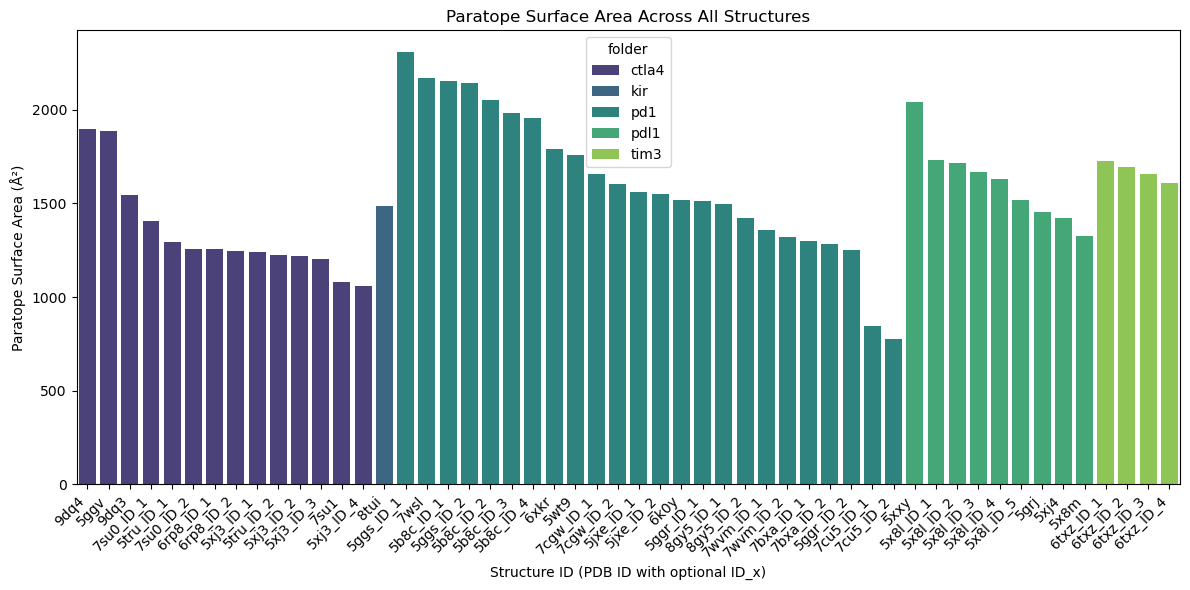

In [ ]:

# Sort as before
df_sorted = df_struc_info.sort_values(by=["folder", "paratope_area"], ascending=[True, False]).copy()


# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="paratope_area", hue="folder", dodge=False, palette="viridis")


plt.title("Paratope Surface Area Across All Structures")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Paratope Surface Area (Å²)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('plots/paratopee_surface_area_across_all_structures.pdf', bbox_inches='tight')
plt.show()



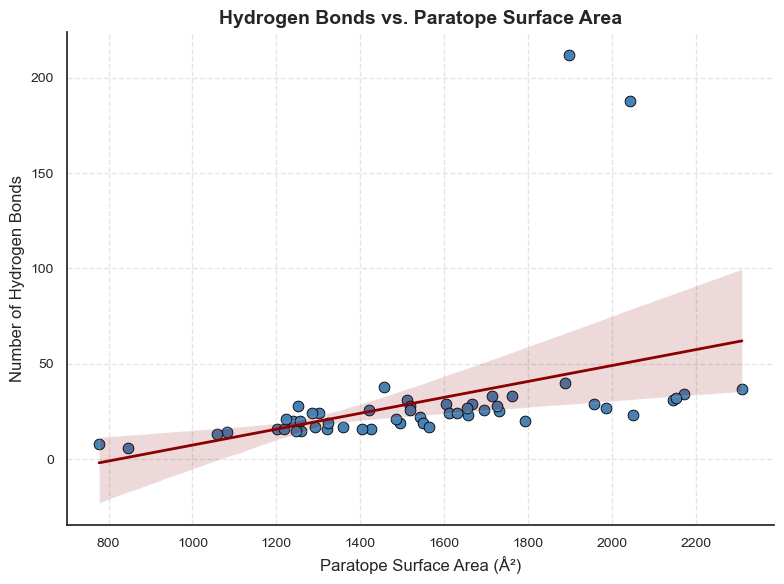

In [ ]:
df_struc_info = pd.read_csv("paratope_surface_hbonds_summary.csv")

plt.figure(figsize=(8, 6))

# Scatterplot
sns.scatterplot(
    data=df_struc_info,
    x="paratope_area",
    y="num_hydrogen_bonds",
    s=60,
    color="steelblue",
    edgecolor="black"
)

# Regression line
sns.regplot(
    data=df_struc_info,
    x="paratope_area",
    y="num_hydrogen_bonds",
    scatter=False,
    color="darkred",
    line_kws={'linewidth': 2}
)

# Styling
plt.title("Hydrogen Bonds vs. Paratope Surface Area", fontsize=14, fontweight="bold")
plt.xlabel("Paratope Surface Area (Å²)", fontsize=12)
plt.ylabel("Number of Hydrogen Bonds", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()

# Save (optional)
plt.savefig("plots/hbonds_vs_surface_area.pdf", bbox_inches='tight')
plt.show()


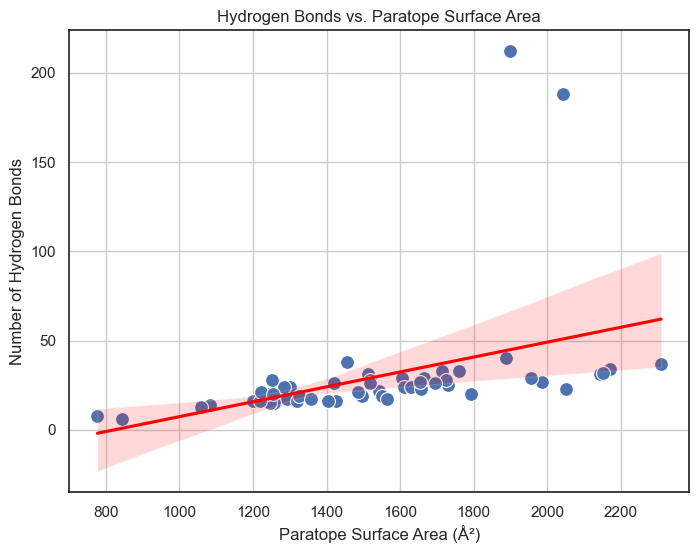

In [ ]:
df_struc_info = pd.read_csv("paratope_surface_hbonds_summary.csv")

# Scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="paratope_area", y="num_hydrogen_bonds", s=100)
sns.regplot(data=df, x="paratope_area", y="num_hydrogen_bonds", scatter=False, color="red")
plt.xlabel("Paratope Surface Area (Å²)")
plt.ylabel("Number of Hydrogen Bonds")
plt.title("Hydrogen Bonds vs. Paratope Surface Area")
plt.grid(True)
plt.show()

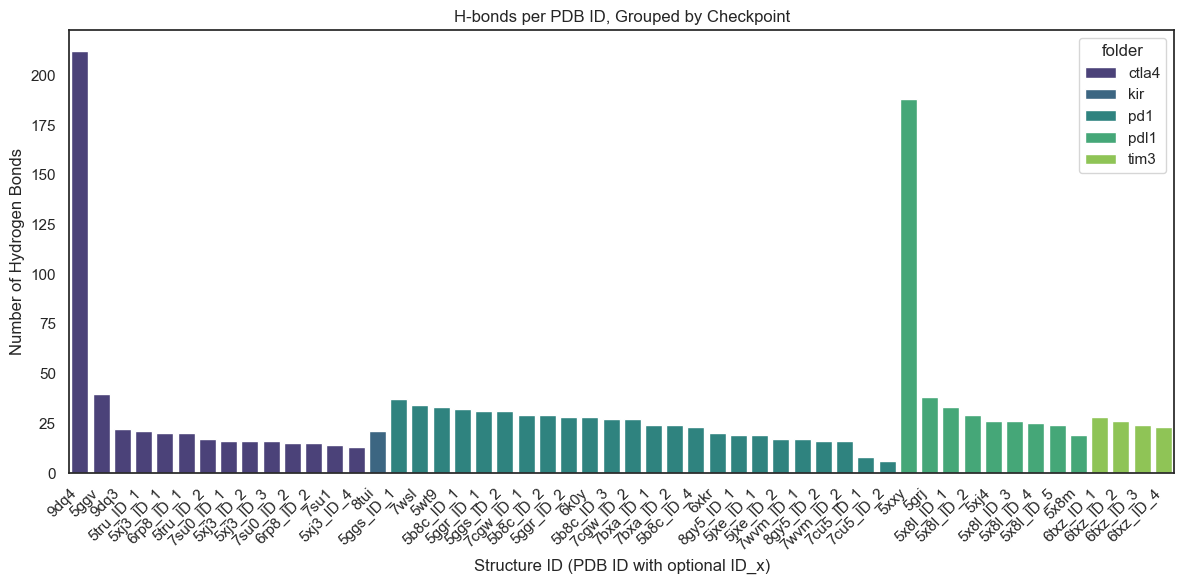

In [ ]:
# from collections import defaultdict, Counter 

# Sort as before
df_sorted_h = df_struc_info.sort_values(by=["folder", "num_hydrogen_bonds"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_h["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_h["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_h["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="num_hydrogen_bonds", hue="folder", dodge=False, palette="viridis")

plt.title("H-bonds per PDB ID, Grouped by Checkpoint")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Hydrogen Bonds")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('plots/h_bonds_per_PDB.pdf', bbox_inches='tight')
plt.show()

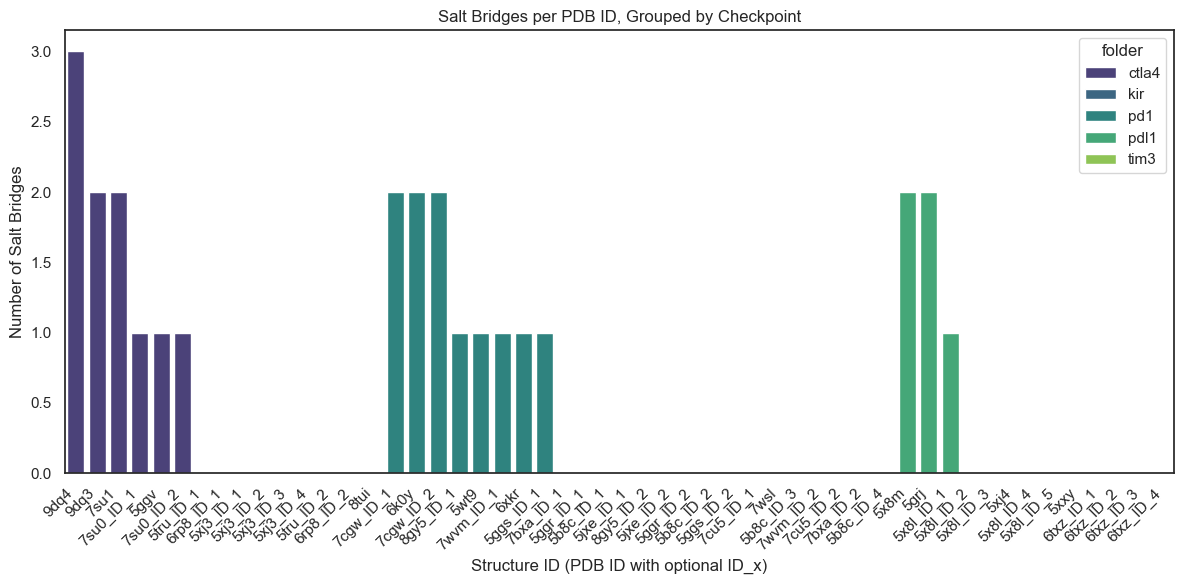

In [ ]:
from collections import defaultdict, Counter

# Sort as before
df_sorted_s = df_struc_info.sort_values(by=["folder", "num_salt_bridges"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_s["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_s["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_s["structure_id"] = structure_ids


# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted_s, x="structure_id", y="num_salt_bridges", hue="folder", dodge=False, palette="viridis")

plt.title("Salt Bridges per PDB ID, Grouped by Checkpoint")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Salt Bridges")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('plots/salt_bridges_per_PDB.pdf', bbox_inches='tight')
plt.show() 

# Binding Score 

In [17]:
from sklearn.preprocessing import MinMaxScaler

#normalizing
scaler = MinMaxScaler()
df = pd.read_csv("paratope_surface_hbonds_salt_bridges_summary.csv")
features = df[["num_hydrogen_bonds", "num_salt_bridges", "paratope_area"]]
normalized = scaler.fit_transform(features)

df_norm = pd.DataFrame(normalized, columns=features.columns)
df_norm["pdb_id"] = df["pdb_id"]  

# Create a binding strength score
weights = {
    "num_hydrogen_bonds": 0.4,
    "num_salt_bridges": 0.4,
    "paratope_area": 0.2
}

df_norm["binding_score"] = (
    df_norm["num_hydrogen_bonds"] * weights["num_hydrogen_bonds"] +
    df_norm["num_salt_bridges"] * weights["num_salt_bridges"] +
    df_norm["paratope_area"] * weights["paratope_area"]
)

# Show top binders
print(df_norm.sort_values("binding_score", ascending=False)[["pdb_id", "binding_score"]])


   pdb_id  binding_score
34   9dq4       0.946239
1    5xxy       0.518688
47   7cgw       0.421995
7    7cgw       0.419402
22   5grj       0.417499
33   6k0y       0.405964
16   9dq3       0.397650
38   5x8m       0.363269
32   5ggs       0.360336
10   5ggv       0.344438
3    7su1       0.321967
20   5wt9       0.314146
43   6xkr       0.292989
31   5x8l       0.279508
18   5ggs       0.260194
27   8gy5       0.252315
24   7wsl       0.236411
13   7su0       0.234503
25   5b8c       0.229987
23   7wvm       0.223532
4    7su0       0.213487
50   5b8c       0.199163
0    5b8c       0.198566
6    5b8c       0.198451
49   5x8l       0.174748
19   6txz       0.166478
2    5x8l       0.161242
46   5x8l       0.160616
28   6txz       0.158448
48   6txz       0.147660
17   5ggr       0.144378
35   6txz       0.143712
12   5x8l       0.135432
26   5jxe       0.126071
9    5jxe       0.124032
39   5xj4       0.122888
15   8tui       0.121516
5    5ggr       0.104701
42   8gy5       0.103942


In [18]:
from collections import Counter, defaultdict

# Sort the dataframe
df_sorted = df_norm.sort_values(
    by=["binding_score", "num_hydrogen_bonds", "num_salt_bridges", "paratope_area"],
    ascending=[False, False, False, False]  # show top-scoring binders first
).copy()
# Count appearances
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build unique structure IDs
structure_ids = []
for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

# Add to DataFrame
df_sorted["structure_id"] = structure_ids

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23772/3630168040.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis")


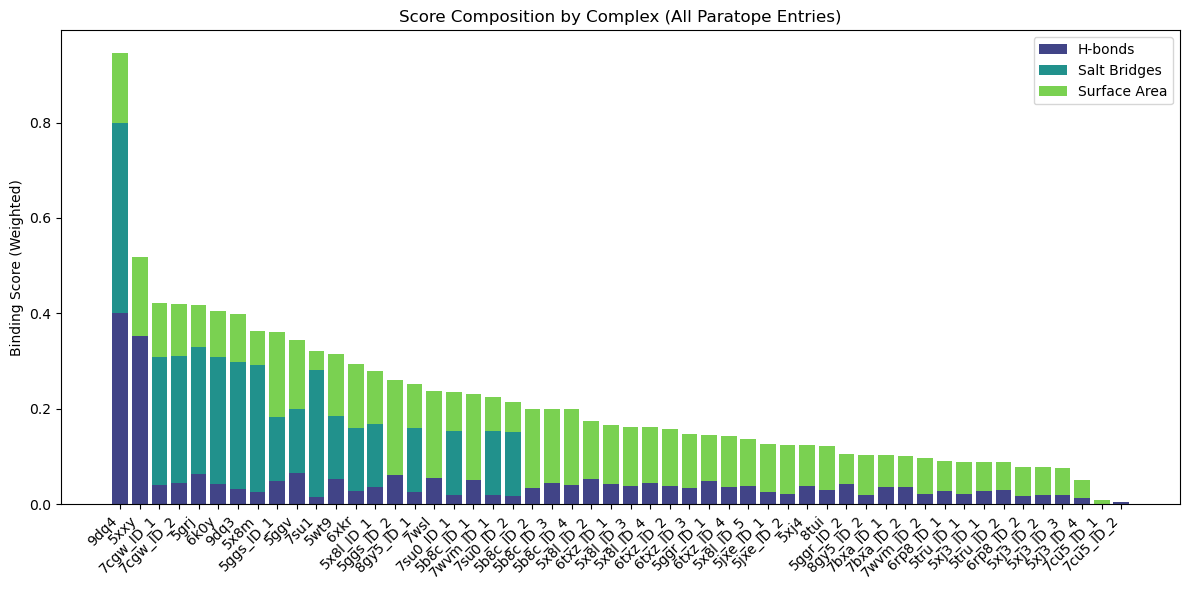

In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Sort by binding score again
top = df_sorted.sort_values("binding_score", ascending=False)

# Use viridis colormap
viridis = cm.get_cmap("viridis")
colors = viridis(np.linspace(0.2, 0.8, 3))

plt.figure(figsize=(12, 6))

# Plot H-bonds
plt.bar(
    top["structure_id"],
    top["num_hydrogen_bonds"] * 0.4,
    label="H-bonds",
    color=colors[0],
    bottom=0
)

# Plot Salt Bridges
plt.bar(
    top["structure_id"],
    top["num_salt_bridges"] * 0.4,
    label="Salt Bridges",
    color=colors[1],
    bottom=top["num_hydrogen_bonds"] * 0.4
)

# Plot Surface Area
plt.bar(
    top["structure_id"],
    top["paratope_area"] * 0.2,
    label="Surface Area",
    color=colors[2],
    bottom=(top["num_hydrogen_bonds"] + top["num_salt_bridges"]) * 0.4
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Binding Score (Weighted)")
plt.title("Score Composition by Complex (All Paratope Entries)")
plt.legend()
plt.tight_layout()
plt.savefig("plots/paratope_binding_affinity_score.pdf", bbox_inches="tight")
plt.show()


# Sequences Paratope

In [20]:
# not unqiue sequences 
import os
from pymol import cmd
from Bio.SeqUtils import seq1
import pandas as pd
from collections import defaultdict, Counter

# Input settings
root_folder = "structures"
cutoff_distance = 5.0  # in Å
results = []

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Replace with actual data

# Loop through all extracted entries
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

    cmd.reinitialize()
    cmd.load(pdb_path)

    # Define selections
    cmd.select("antibody", f"chain {h_chain}+{l_chain}")
    cmd.select("antigen", f"chain {ag_chain}")
    cmd.select("paratope", f"antibody within {cutoff_distance} of antigen")

    # Extract unique residues from epitope
    model = cmd.get_model("paratope")
    seen = set()
    residues = []
    for atom in model.atom:
        res_id = (atom.chain, atom.resi)
        if res_id not in seen:
            seen.add(res_id)
            residues.append(atom.resn)

    sequence = ''.join(seq1(res) for res in residues if res != "HOH")

    # Collect results
    results.append({
        "pdb_id": pdb_id,
        "H_chain": h_chain,
        "L_chain": l_chain,
        "antigen_chain": ag_chain,
        "paratope_sequence": sequence,
        "folder": os.path.basename(dirpath)
    })

# Convert to DataFrame
df_seq = pd.DataFrame(results)

# Assign unique structure_id like in other analyses
df_seq = df_seq.sort_values(by=["folder", "paratope_sequence"], ascending=[True, False]).copy()
id_frequencies = Counter(df_seq["pdb_id"])
id_tracker = defaultdict(int)

structure_ids = []
for pdb_id in df_seq["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_seq["structure_id"] = structure_ids

# Save CSV
df_seq.to_csv("paratope_sequences_summary.csv", index=False)
print("Summary table saved to 'paratope_sequences_summary.csv'")

# Save FASTA
with open("paratope_sequences.fasta", "w") as f:
    for _, row in df_seq.iterrows():
        f.write(f">{row['structure_id']}\n{row['paratope_sequence']}\n")

print("FASTA file saved to 'paratope_sequences.fasta'")

# Add sequence to df_sorted

df_sorted_seq = df_seq.sort_values(by=["folder", "paratope_sequence"], ascending=[True, False]).copy()
   


Processing 5b8c...
Processing 5xxy...
Processing 5x8l...
Processing 7su1...
Processing 7su0...
Processing 5ggr...
Processing 5b8c...
Processing 7cgw...
Processing 5tru...
Processing 5jxe...
Processing 5ggv...
Processing 7bxa...
Processing 5x8l...
Processing 7su0...
Processing 7bxa...
Processing 8tui...
Processing 9dq3...
Processing 5ggr...
Processing 5ggs...
Processing 6txz...
Processing 5wt9...
Processing 6rp8...
Processing 5grj...
Processing 7wvm...
Processing 7wsl...
Processing 5b8c...
Processing 5jxe...
Processing 8gy5...
Processing 6txz...
Processing 7cu5...
Processing 5xj3...
Processing 5x8l...
Processing 5ggs...
Processing 6k0y...
Processing 9dq4...
Processing 6txz...
Processing 6rp8...
Processing 5xj3...
Processing 5x8m...
Processing 5xj4...
Processing 7wvm...
Processing 5tru...
Processing 8gy5...
Processing 6xkr...
Processing 5xj3...
Processing 5xj3...
Processing 5x8l...
Processing 7cgw...
Processing 6txz...
Processing 5x8l...
Processing 5b8c...
Processing 7cu5...
Summary tabl

In [29]:
print(df_sorted_seq)

   pdb_id H_chain L_chain antigen_chain  \
10   5ggv       H       L             Y   
21   6rp8       h       l             c   
36   6rp8       H       L             C   
8    5tru       h       l             c   
44   5xj3       A       B             C   
45   5xj3       J       K             L   
30   5xj3       G       H             I   
37   5xj3       D       E             F   
41   5tru       H       L             C   
16   9dq3       H       L             C   
34   9dq4       H       L             A   
4    7su0       H       L             C   
13   7su0       I       M             D   
3    7su1       H       L             C   
15   8tui       H       L             A   
7    7cgw       H       L             P   
24   7wsl       H       L             D   
32   5ggs       C       D             Y   
18   5ggs       A       B             Z   
26   5jxe       G       F             A   
0    5b8c       K       J             L   
50   5b8c       H       G             I   
9    5jxe  

## Identiy Matrix

In [23]:
from Bio import SeqIO # to read sequences from a FASTA file
from Bio import pairwise2 # pairwise sequence alignments
import pandas as pd

# Load your sequences
records = list(SeqIO.parse("paratope_sequences.fasta", "fasta"))

# Initialize identity matrix
matrix = []

# Compare each pair
for r1 in records:
    row = []
    for r2 in records:
        alignments = pairwise2.align.globalxx(r1.seq, r2.seq) # Align two sequences (whole sequence)
        best = alignments[0]
        identity = best.score / max(len(r1.seq), len(r2.seq)) * 100  # identiy in % -> (number of matches) / (length of longer sequence) × 100
        row.append(round(identity, 2))
    matrix.append(row)

# Create a DataFrame
ids = [rec.id for rec in records]
df_identity = pd.DataFrame(matrix, index=ids, columns=ids)

# Save & show
df_identity.to_csv("paratope_sequence_comparison_matrix.csv")
print(" Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'")
print(df_identity)


/opt/anaconda3/envs/pymol-env/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


 Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'
             5ggv  6rp8_ID_1  6rp8_ID_2  5tru_ID_1  5xj3_ID_1  5xj3_ID_2  \
5ggv       100.00      35.71      32.14      35.71      39.29      39.29   
6rp8_ID_1   35.71     100.00      95.00      90.91      90.48      81.82   
6rp8_ID_2   32.14      95.00     100.00      90.91      85.71      81.82   
5tru_ID_1   35.71      90.91      90.91     100.00      86.36      86.36   
5xj3_ID_1   39.29      90.48      85.71      86.36     100.00      90.91   
5xj3_ID_2   39.29      81.82      81.82      86.36      90.91     100.00   
5xj3_ID_3   32.14      85.00      85.00      77.27      85.71      81.82   
5xj3_ID_4   42.86      86.96      82.61      86.96      91.30      91.30   
5tru_ID_2   39.29      90.48      85.71      90.91      85.71      86.36   
9dq3        39.29      52.00      52.00      56.00      56.00      60.00   
9dq4        39.29      48.15      48.15      51.85      51.85      55.56   
7su0_ID_1  

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23772/3904543579.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{x:.0f}")


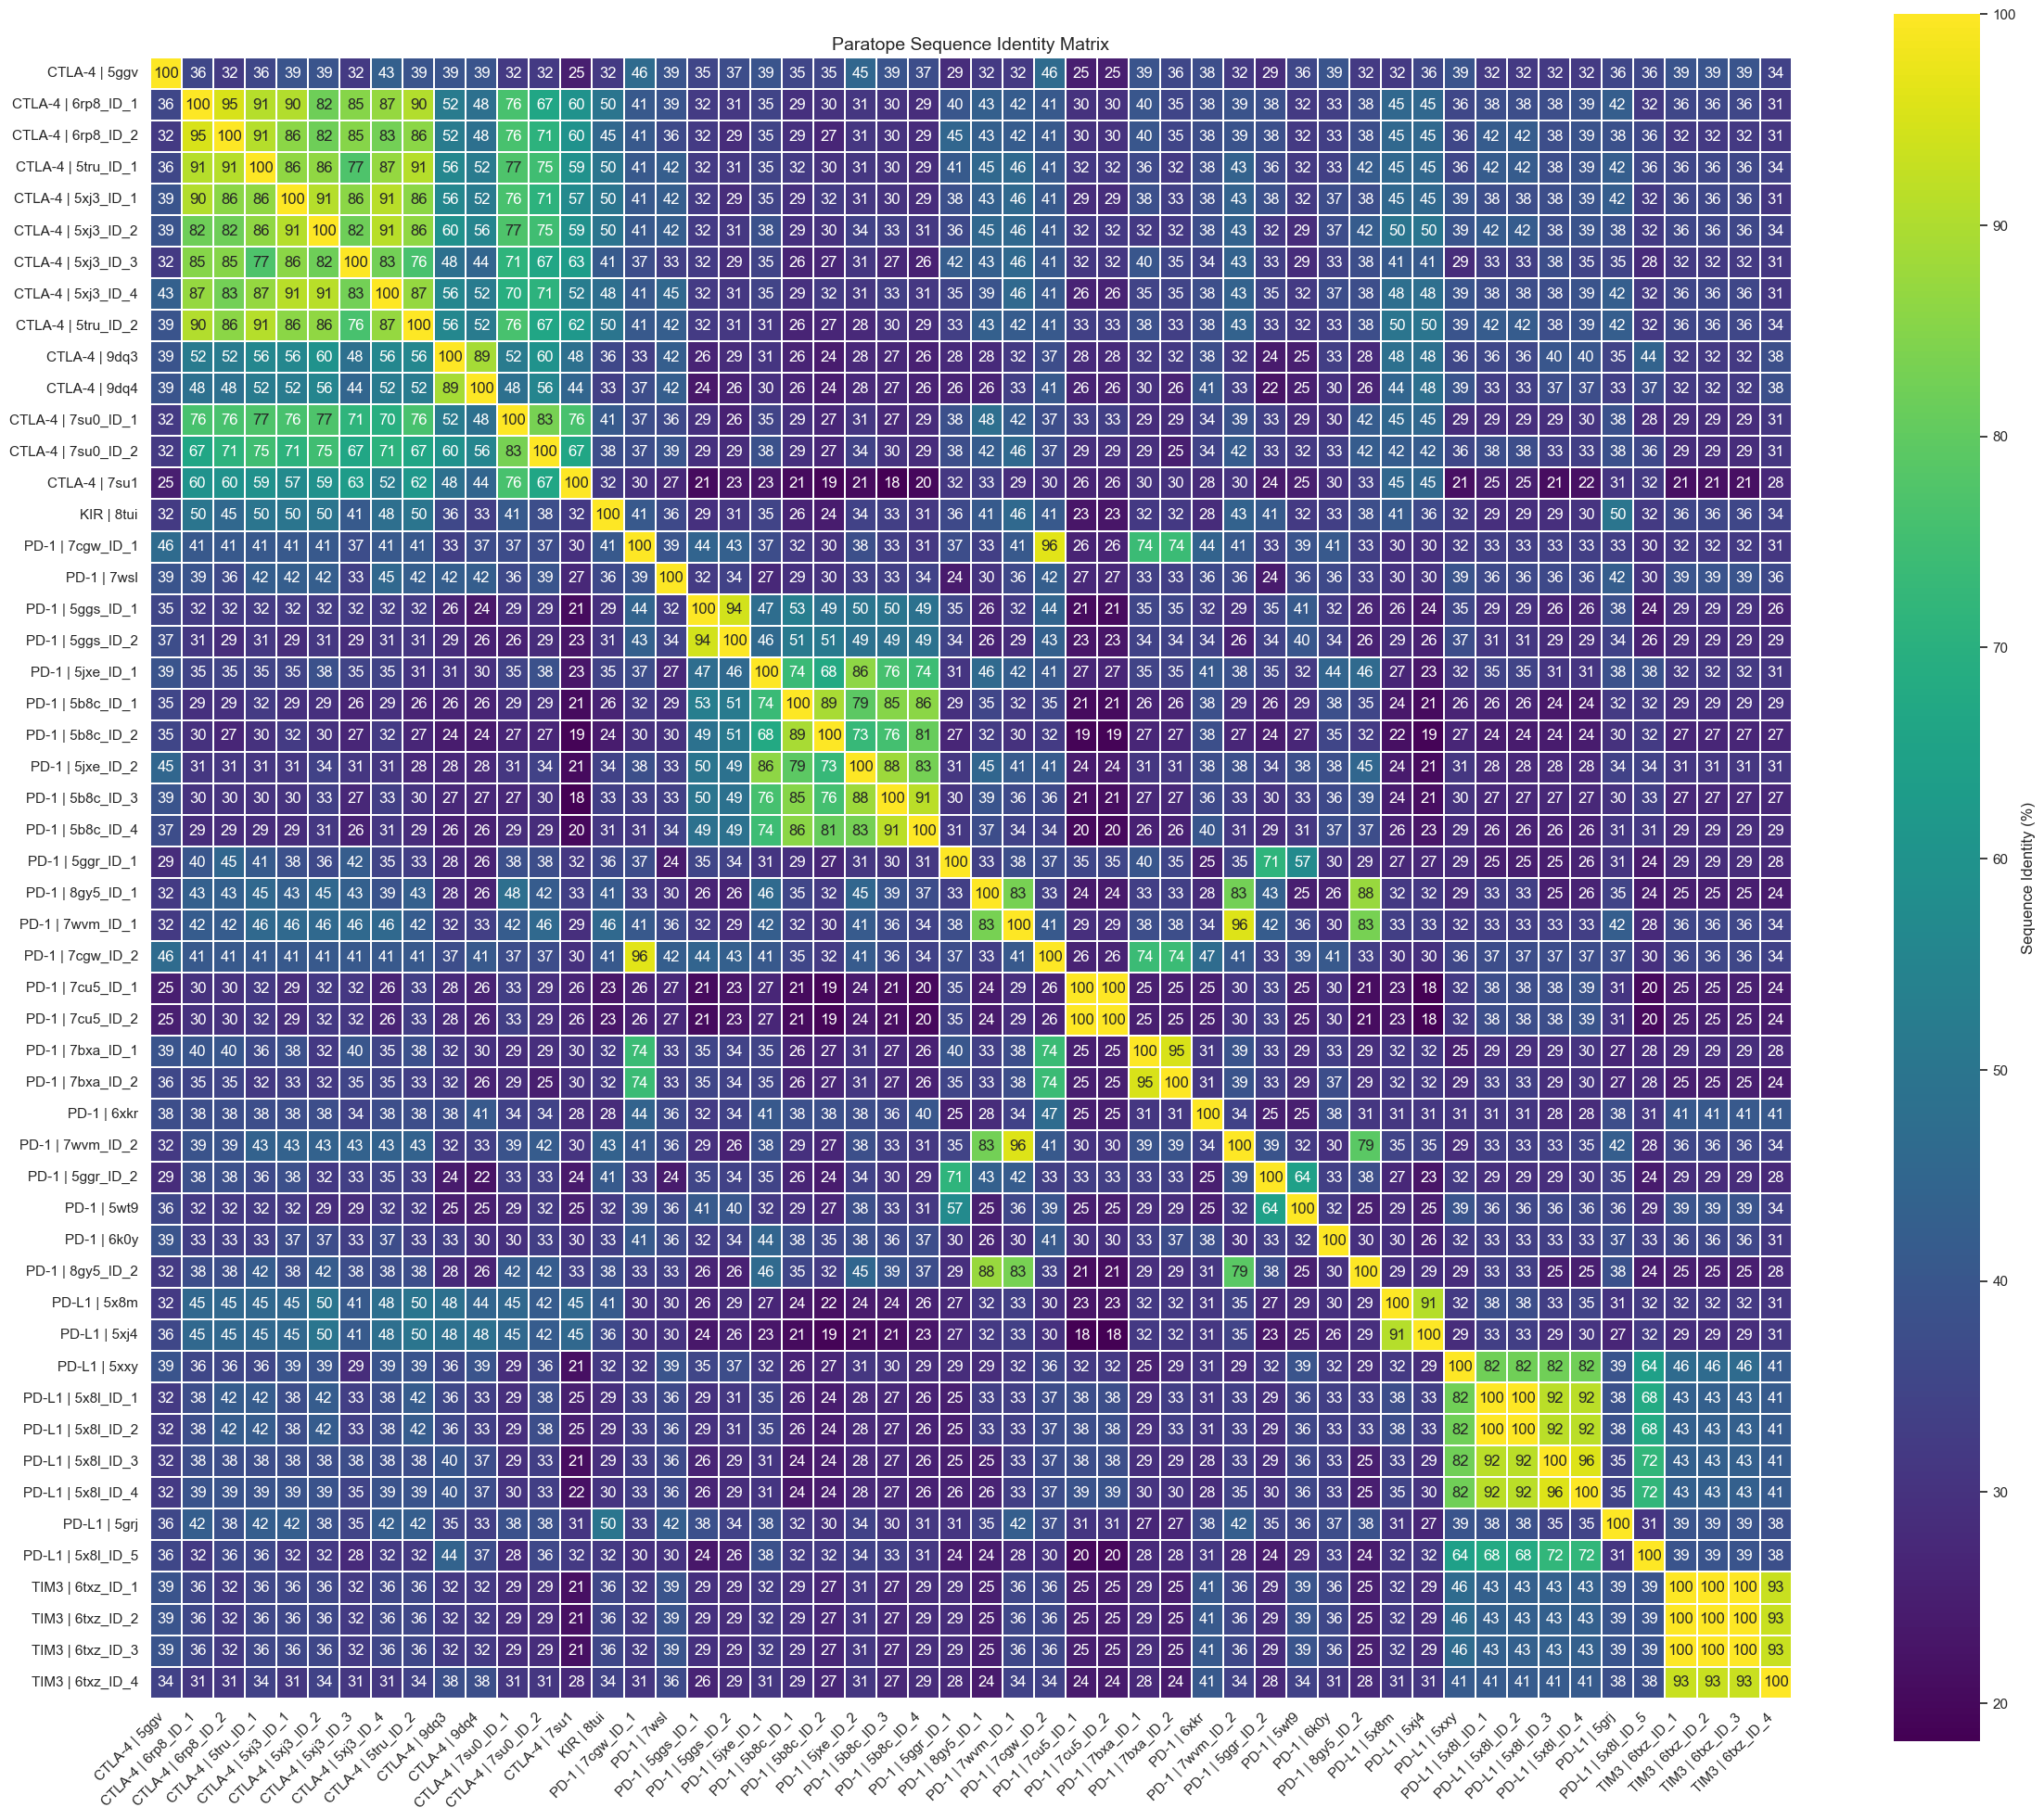

Cleaned-up heatmap saved as 'paratope_identity_heatmap_final.png'


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from collections import defaultdict, Counter

checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']

pdb_ids = {
    'PD-1': pd1['pdb'].unique().tolist(), # mit variable funktioniert unique nicht
    'PD-L1': pdl1['pdb'].unique().tolist(),
    'CTLA-4': ctla4['pdb'].unique().tolist(),
    'KIR': kir['pdb'].unique().tolist(),
    'LAG3': lag3['pdb'].unique().tolist(),
    'TIM3': tim3['pdb'].unique().tolist(),
}

# Create mapping from PDB ID → Checkpoint
pdb_to_checkpoint = {}
for checkpoint, pdb_list in pdb_ids.items():
    for pdb in pdb_list:
        pdb_to_checkpoint[pdb.lower()] = checkpoint

# Update row and column labels using base PDB ID
def get_checkpoint_label(pdb_id):
    base_id = pdb_id.lower().split('_')[0]  # e.g. "5x8l_ID_1" → "5x8l"
    checkpoint = pdb_to_checkpoint[base_id]
    return f"{checkpoint} | {pdb_id}"

df_identity = df_identity.copy()
df_identity.index = [get_checkpoint_label(p) for p in df_identity.index]
df_identity.columns = [get_checkpoint_label(p) for p in df_identity.columns]



annot_data = df_identity.applymap(lambda x: f"{x:.0f}")
mask = None

plt.figure(figsize=(24, 20))
sns.set(style="white", font_scale=1.0)
# annot_data = df.applymap(lambda x: f"{int(x)}" if x >= 70 else "")


ax = sns.heatmap(
    df_identity, 
    annot=annot_data, 
    fmt="", 
    cmap="viridis", 
    mask=mask,
    square=True, 
    linewidths=0.3, 
    cbar_kws={"label": "Sequence Identity (%)"}
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Paratope Sequence Identity Matrix", fontsize=14)
plt.tight_layout()

plt.savefig("paratope_identity_heatmap_final.png", dpi=300)
plt.show()

print("Cleaned-up heatmap saved as 'paratope_identity_heatmap_final.png'")

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2478452501.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")


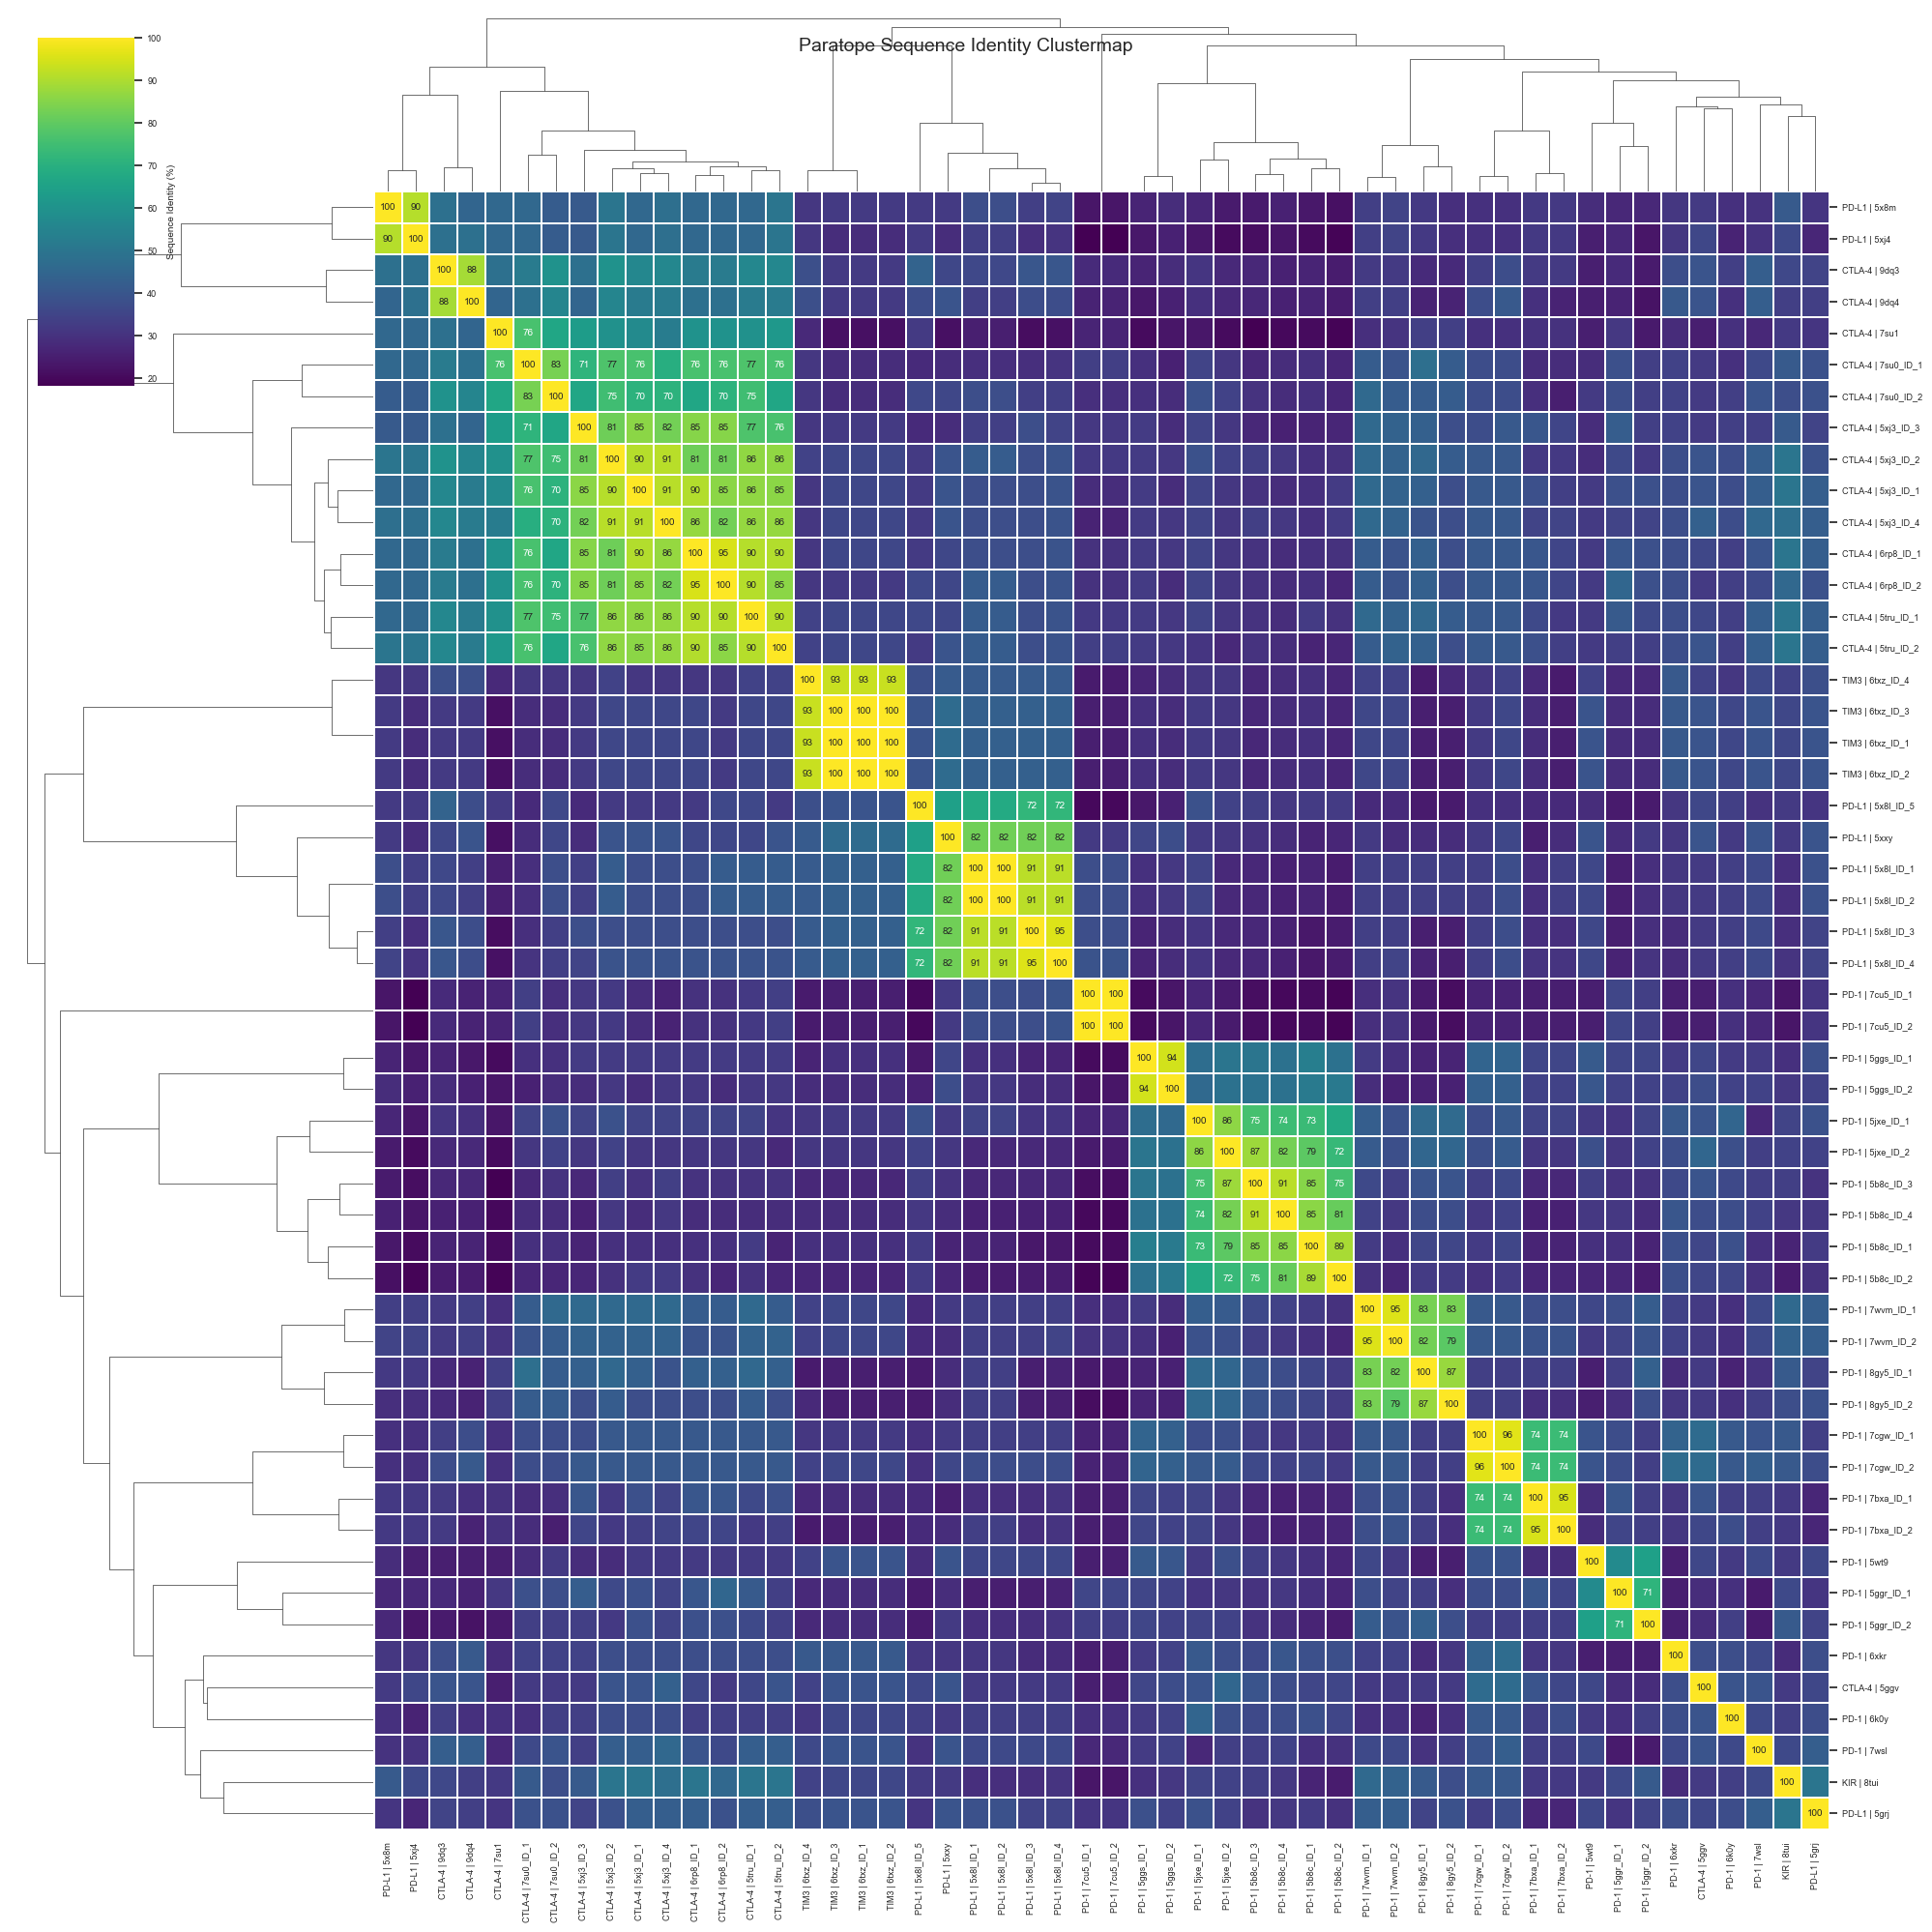

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: annotate only high identities
annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")

# Seaborn clustermap
sns.set(font_scale=0.6)  # smaller font for big matrices
g = sns.clustermap(
    df_identity,
    cmap="viridis",
    figsize=(20, 20),
    annot=annot_data,
    fmt="",
    linewidths=0.3,
    cbar_kws={"label": "Sequence Identity (%)"},
    dendrogram_ratio=(.2, .1),  # ratio for row/col dendrograms
    xticklabels=True,
    yticklabels=True
)



# Optional: save as high-res PDF
g.fig.suptitle("Paratope Sequence Identity Clustermap", fontsize=14)
plt.savefig("paratope_clustermap.pdf", dpi=300, bbox_inches="tight")
plt.show()


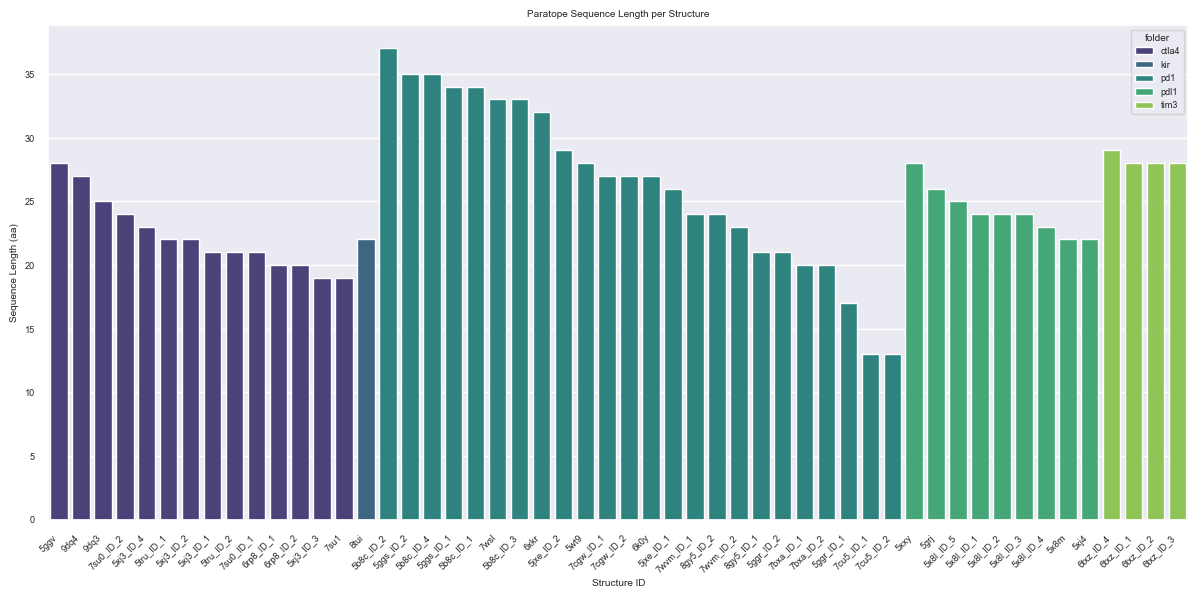

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add a column with the sequence length
df_seq["paratope_length"] = df_seq["paratope_sequence"].str.len()

# Sort for better visualization (optional)
df_seq_sorted_by_length = df_seq.sort_values(by=["folder", "paratope_length"], ascending=[True, False])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_seq_sorted_by_length, x="structure_id", y="paratope_length", hue="folder", dodge=False, palette="viridis")

plt.title("Paratope Sequence Length per Structure")
plt.xlabel("Structure ID")
plt.ylabel("Sequence Length (aa)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("paratope_sequence_lengths.pdf", bbox_inches='tight')
plt.show()


In [26]:
# df_norm.to_csv('binding_scores.csv', index=False)


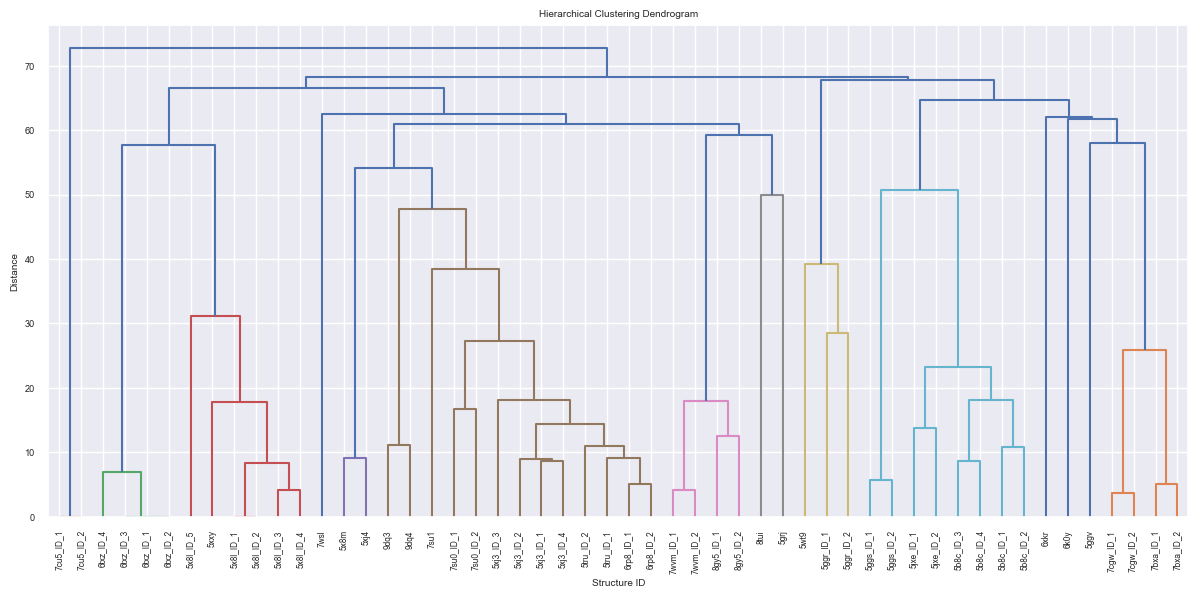

Cluster labels saved to 'cluster_labels.csv'


In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load the distance matrix ===
# Replace with your actual distance matrix CSV
df_distance = pd.read_csv("paratope_sequence_comparison_matrix.csv", index_col=0)

# === Step 2: Convert similarity to distance if needed ===
# If your matrix contains similarity (e.g. % identity), convert it:
df_dist = 100 - df_distance  # assuming 100% is max similarity

# === Step 3: Condense the distance matrix ===
# Hierarchical clustering needs a condensed distance matrix (lower triangle)
condensed_dist = df_dist.values[np.triu_indices_from(df_dist, k=1)]

# === Step 4: Perform hierarchical clustering ===
Z = linkage(condensed_dist, method='average')  # or 'ward', 'single', etc.

# === Step 5: Assign clusters ===
# Adjust t or n_clusters as needed
n_clusters = 6
clusters = fcluster(Z, n_clusters, criterion='maxclust')

# === Step 6: Create a labeled DataFrame ===
df_labels = pd.DataFrame({
    'structure_id': df_dist.index,
    'cluster': clusters
})

# === Step 7: Plot dendrogram ===
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df_dist.index.tolist(), leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Structure ID")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# === Step 8: Save results ===
df_labels.to_csv("cluster_labels.csv", index=False)
print("Cluster labels saved to 'cluster_labels.csv'")


In [ ]:
df.rename(columns={"folder": "checkpoint"}, inplace=True)
print(df)


   pdb_id H_chain L_chain antigen_chain  paratope_area  num_hydrogen_bonds  \
0    5x8l       H       M             C    1714.077026                  33   
1    5xxy       H       L             A    2043.012085                 188   
2    5b8c       K       J             L    1955.864258                  29   
3    5ggv       H       L             Y    1888.336914                  40   
4    6txz       H       L             A    1693.345337                  26   
5    7wvm       A       B             E    1319.529053                  16   
6    6txz       K       O             D    1725.092407                  28   
7    7su0       I       M             D    1403.515625                  16   
8    7cu5       A       A             Q     845.327209                   6   
9    6rp8       H       L             C    1255.458130                  20   
10   5xj3       G       H             I    1059.592773                  13   
11   5x8l       S       N             D    1629.124878          

In [40]:

df_struct = pd.read_csv("paratope_surface_hbonds_salt_bridges_summary.csv")

all_df = pd.merge(df_struct, df_sorted_seq[["pdb_id", "paratope_sequence"]], on="pdb_id", how="left")

all_df = pd.merge(all_df, df_norm[["pdb_id", "binding_score"]], on="pdb_id", how="left")

all_df.to_csv("structural_paratope_all_information_final.csv", index=False)



# Do cluster have different binding affinities? 

In [ ]:
# Neuer Versuch für Bindungsstärke zwischne den Clustern

manual_clusters = {
    "Cluster 1": ["5x8m", "5xj4", "9dq3", "9dq4", "7su1", "7su0", "5xj3", "6rp8", "5tru" ],
    "Cluster 2": ["6txz"],
    "Cluster 3": ["5xB1", "5xxy"],
    "Cluster 4": ["5ggs", "5jxe", "5b8c"],
    "Cluster 5": ["7wvm", "8gy5"],
    "Cluster 6": ["7cgw", "7bxa"],
    "Cluster 7": ["5wt9", "5ggr"]
}

# df -> Bindungsstärke

import pandas as pd


# 1. Manuelles Cluster-Dict in Liste umwandeln
cluster_rows = []
for cluster_name, pdb_list in manual_clusters.items():
    for pdb in pdb_list:
        cluster_rows.append({"pdb_id": pdb, "cluster": cluster_name})

# 2. DataFrame daraus
cluster_df = pd.DataFrame(cluster_rows)

# 3. Merge mit Haupt-DataFrame (z. B. mit binding_score)
merged_df = cluster_df.merge(all_df[["pdb_id", "binding_score", "checkpoint"]], on="pdb_id", how="left")

# Ergebnis anschauen
print(merged_df)

   pdb_id    cluster  binding_score checkpoint
0    5x8m  Cluster 1       0.363269      PD-L1
1    5xj4  Cluster 1       0.122888      PD-L1
2    9dq3  Cluster 1       0.397650     CTLA-4
3    9dq4  Cluster 1       0.946239     CTLA-4
4    7su1  Cluster 1       0.321967     CTLA-4
5    7su0  Cluster 1       0.213487     CTLA-4
6    7su0  Cluster 1       0.234503     CTLA-4
7    5xj3  Cluster 1       0.087400     CTLA-4
8    5xj3  Cluster 1       0.074734     CTLA-4
9    5xj3  Cluster 1       0.077047     CTLA-4
10   5xj3  Cluster 1       0.050417     CTLA-4
11   6rp8  Cluster 1       0.078650     CTLA-4
12   6rp8  Cluster 1       0.089596     CTLA-4
13   5tru  Cluster 1       0.088670     CTLA-4
14   5tru  Cluster 1       0.087214     CTLA-4
15   6txz  Cluster 2       0.166478       TIM3
16   6txz  Cluster 2       0.143712       TIM3
17   6txz  Cluster 2       0.147660       TIM3
18   6txz  Cluster 2       0.158448       TIM3
19   5xB1  Cluster 3            NaN        NaN
20   5xxy  Cl

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2830967183.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")


(0.0, 0.6)

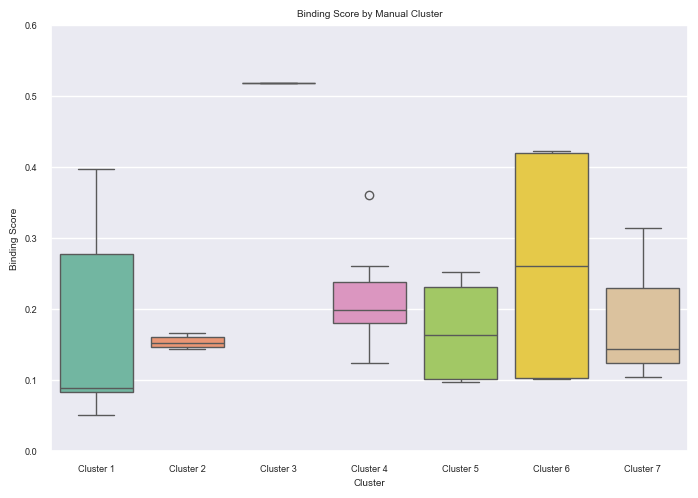

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")

plt.title("Binding Score by Manual Cluster")
plt.xlabel("Cluster")
plt.ylabel("Binding Score")
plt.tight_layout()
plt.ylim(0, 0.6)


In [ ]:
from scipy.stats import kruskal

# 1. Daten nach Cluster gruppieren
grouped_scores = [
    group["binding_score"].dropna().values
    for name, group in merged_df.groupby("cluster")
]

# 2. Kruskal–Wallis-Test
stat, p = kruskal(*grouped_scores)

print(f"Kruskal–Wallis-Test: H = {stat:.3f}, p = {p:.4e}")


Kruskal–Wallis-Test: H = 5.459, p = 4.8641e-01



=== Cluster 1 ===
   pdb_id  binding_score checkpoint
0    5x8m       0.363269      PD-L1
1    5xj4       0.122888      PD-L1
2    9dq3       0.397650     CTLA-4
3    9dq4       0.946239     CTLA-4
4    7su1       0.321967     CTLA-4
5    7su0       0.213487     CTLA-4
6    7su0       0.234503     CTLA-4
7    5xj3       0.087400     CTLA-4
8    5xj3       0.074734     CTLA-4
9    5xj3       0.077047     CTLA-4
10   5xj3       0.050417     CTLA-4
11   6rp8       0.078650     CTLA-4
12   6rp8       0.089596     CTLA-4
13   5tru       0.088670     CTLA-4
14   5tru       0.087214     CTLA-4


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


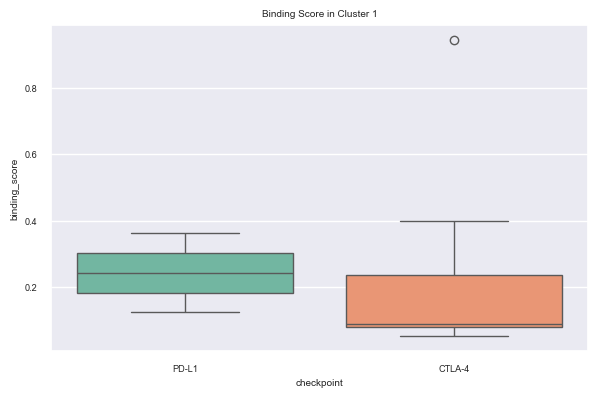

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")



=== Cluster 2 ===
   pdb_id  binding_score checkpoint
15   6txz       0.166478       TIM3
16   6txz       0.143712       TIM3
17   6txz       0.147660       TIM3
18   6txz       0.158448       TIM3


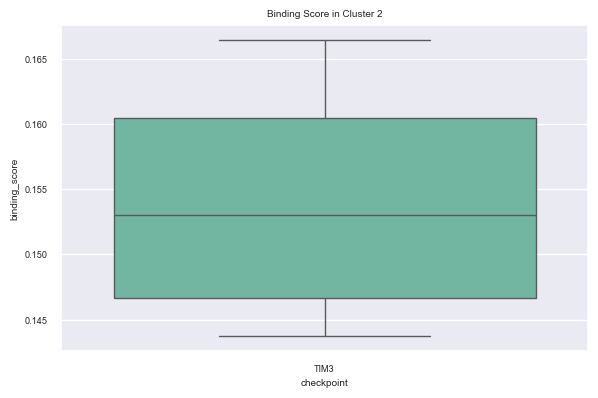


=== Cluster 3 ===
   pdb_id  binding_score checkpoint
19   5xB1            NaN        NaN
20   5xxy       0.518688      PD-L1


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


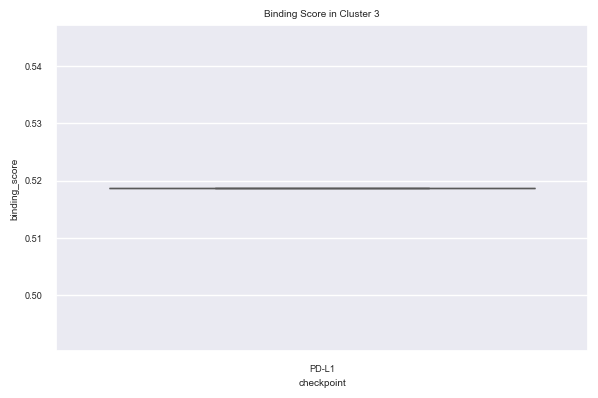


=== Cluster 4 ===
   pdb_id  binding_score checkpoint
21   5ggs       0.260194       PD-1
22   5ggs       0.360336       PD-1
23   5jxe       0.124032       PD-1
24   5jxe       0.126071       PD-1
25   5b8c       0.198566       PD-1
26   5b8c       0.229987       PD-1
27   5b8c       0.199163       PD-1
28   5b8c       0.198451       PD-1


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


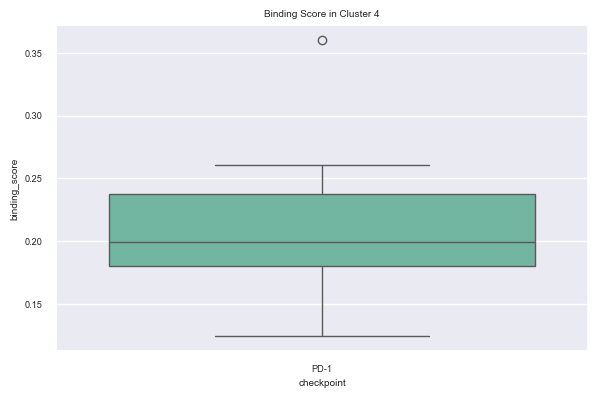


=== Cluster 5 ===
   pdb_id  binding_score checkpoint
29   7wvm       0.223532       PD-1
30   7wvm       0.097149       PD-1
31   8gy5       0.103942       PD-1
32   8gy5       0.252315       PD-1


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


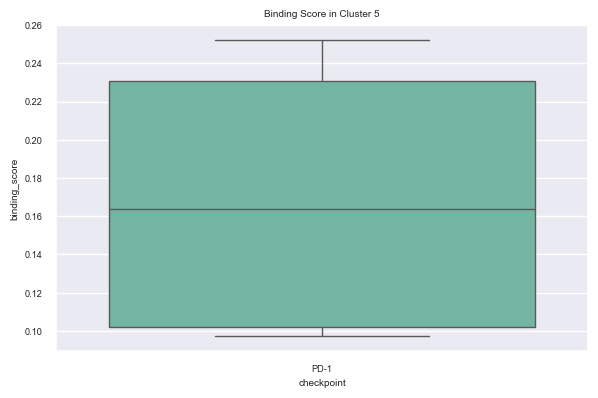


=== Cluster 6 ===
   pdb_id  binding_score checkpoint
33   7cgw       0.419402       PD-1
34   7cgw       0.421995       PD-1
35   7bxa       0.103305       PD-1
36   7bxa       0.101257       PD-1


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


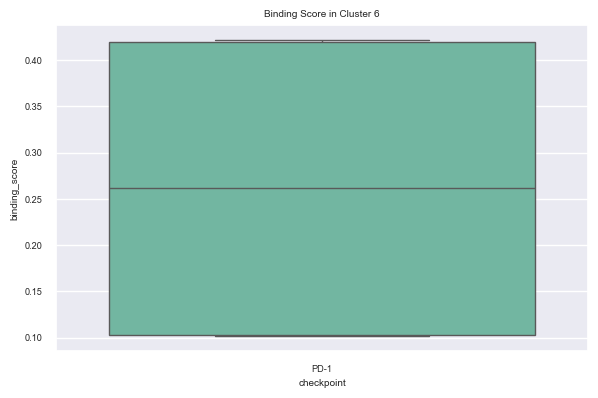


=== Cluster 7 ===
   pdb_id  binding_score checkpoint
37   5wt9       0.314146       PD-1
38   5ggr       0.144378       PD-1
39   5ggr       0.104701       PD-1


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


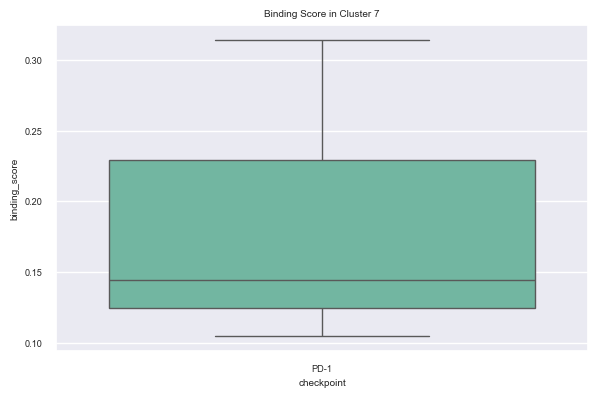

In [ ]:
for cluster_name, group in merged_df.groupby("cluster"):
    print(f"\n=== {cluster_name} ===")
    print(group[["pdb_id", "binding_score", "checkpoint"]])
    
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")
    plt.title(f"Binding Score in {cluster_name}")
    plt.tight_layout()
    plt.show()



/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


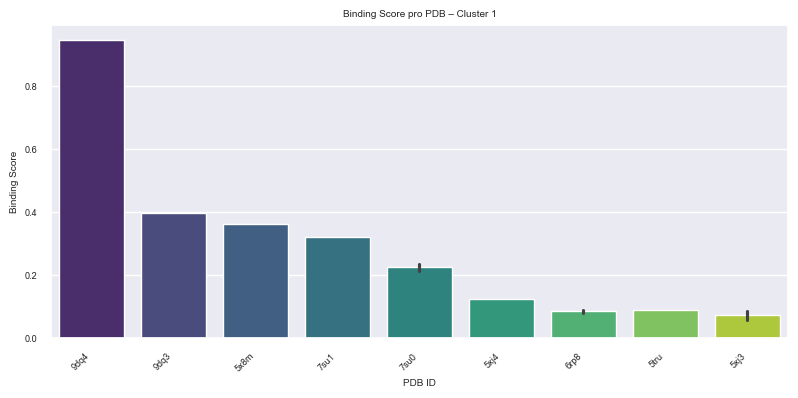

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


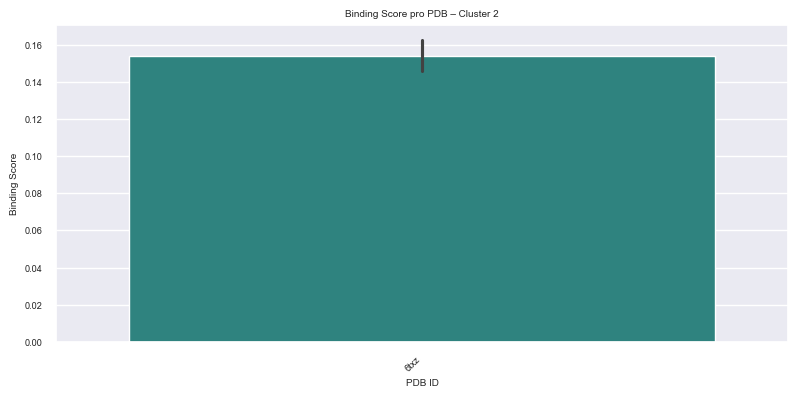

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


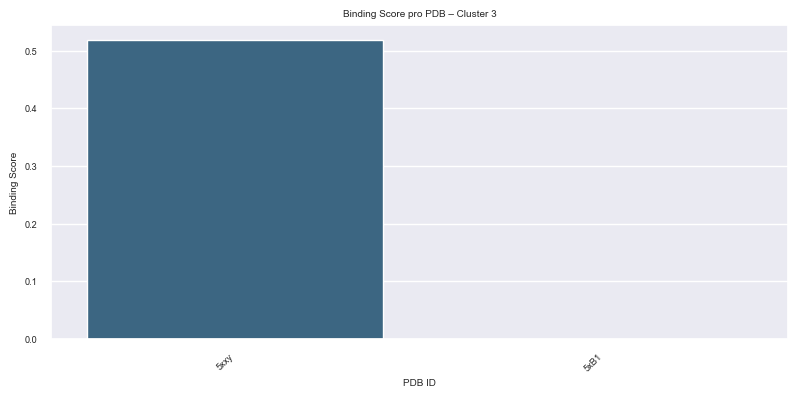

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


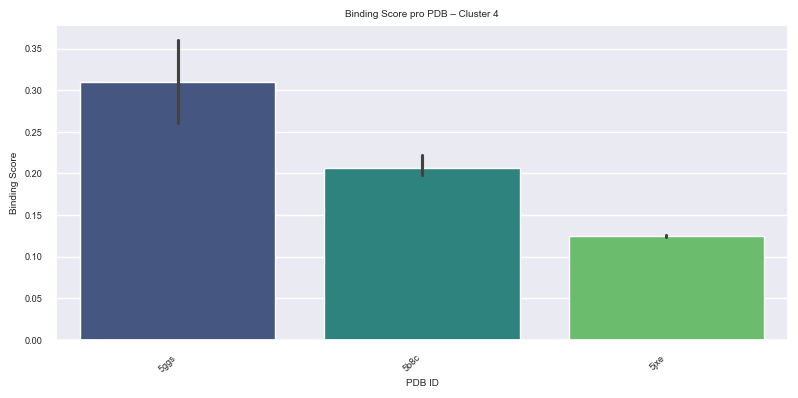

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


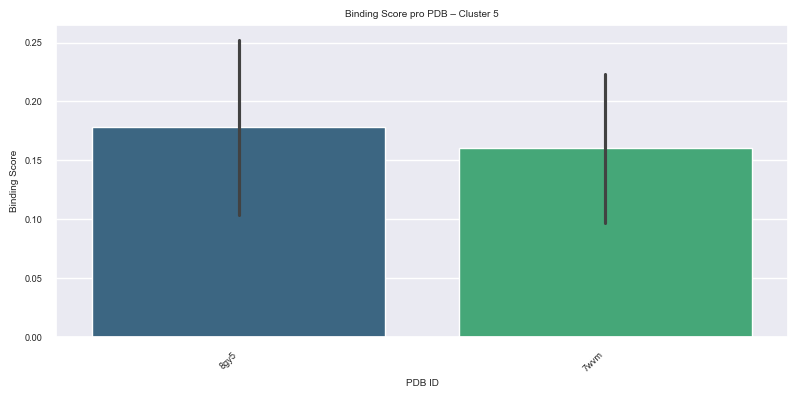

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


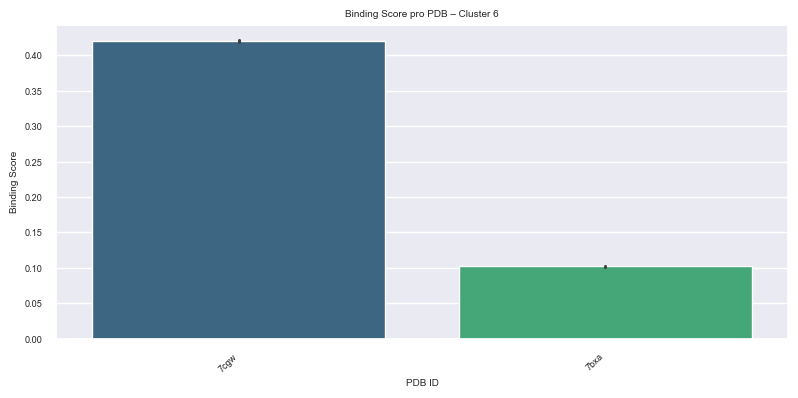

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


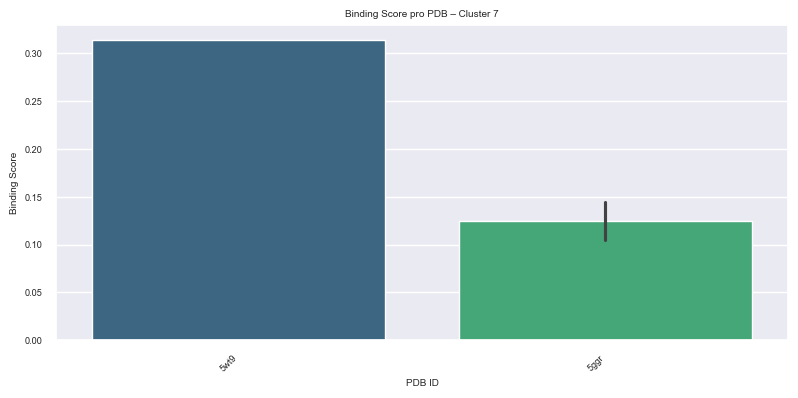

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clusterliste ermitteln
clusters = merged_df["cluster"].unique()

# Plot pro Cluster
for cluster_name in clusters:
    subset = merged_df[merged_df["cluster"] == cluster_name].sort_values("binding_score", ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
    plt.title(f"Binding Score pro PDB – {cluster_name}")
    plt.xlabel("PDB ID")
    plt.ylabel("Binding Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Mann–Whitney U-Statistik: 62461.00
P-Wert: 0.4780


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/1719643986.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#66c2bf", "#fc626c"])


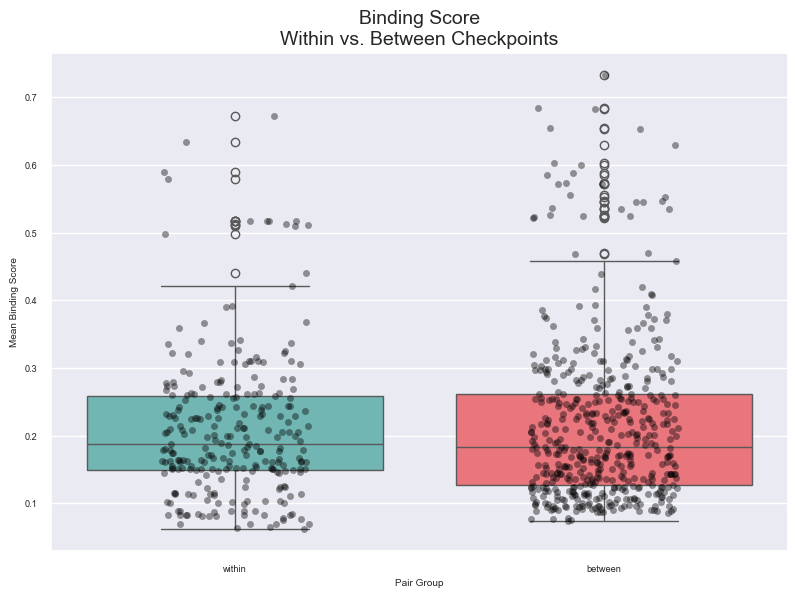

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import mannwhitneyu

# Step 1: Drop NaNs in binding_score or checkpoint before pairing
clean_df = merged_df.dropna(subset=["binding_score", "checkpoint"])

# Step 2: Generate all pairwise combinations
pairs = []
for (p1, row1), (p2, row2) in combinations(clean_df.iterrows(), 2):
    score1 = row1["binding_score"]
    score2 = row2["binding_score"]

    if pd.notna(score1) and pd.notna(score2):
        pairs.append({
            "pdb_1": row1["pdb_id"],
            "pdb_2": row2["pdb_id"],
            "mean_binding": (score1 + score2) / 2,
            "same_checkpoint": row1["checkpoint"] == row2["checkpoint"]
        })

# Step 3: Create DataFrame and group labels
df_binding_pairs = pd.DataFrame(pairs)
df_binding_pairs = df_binding_pairs.dropna(subset=["mean_binding"])
df_binding_pairs["group"] = df_binding_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Step 4: Statistical test
within = df_binding_pairs[df_binding_pairs["group"] == "within"]["mean_binding"]
between = df_binding_pairs[df_binding_pairs["group"] == "between"]["mean_binding"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")

# Step 5: Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#66c2bf", "#fc626c"])
sns.stripplot(data=df_binding_pairs, x="group", y="mean_binding", color='black', alpha=0.4, jitter=0.2)

plt.title("Binding Score\nWithin vs. Between Checkpoints", fontsize=14)
plt.ylabel("Mean Binding Score")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


In [ ]:
df_identity.index = df_identity.index.str.lower()
df_identity.columns = df_identity.columns.str.lower()
merged_df["pdb_id"] = merged_df["pdb_id"].str.lower()
print(df_identity)

                    ctla-4 | 5ggv  ctla-4 | 6rp8_id_1  ctla-4 | 6rp8_id_2  \
ctla-4 | 5ggv              100.00               35.71               32.14   
ctla-4 | 6rp8_id_1          35.71              100.00               95.00   
ctla-4 | 6rp8_id_2          32.14               95.00              100.00   
ctla-4 | 5tru_id_1          35.71               90.91               90.91   
ctla-4 | 5xj3_id_1          39.29               90.48               85.71   
ctla-4 | 5xj3_id_2          39.29               81.82               81.82   
ctla-4 | 5xj3_id_3          32.14               85.00               85.00   
ctla-4 | 5xj3_id_4          42.86               86.96               82.61   
ctla-4 | 5tru_id_2          39.29               90.48               85.71   
ctla-4 | 9dq3               39.29               52.00               52.00   
ctla-4 | 9dq4               39.29               48.15               48.15   
ctla-4 | 7su0_id_1          32.14               76.19               76.19   

In [ ]:
from itertools import combinations
import pandas as pd

pairs = []

# Extrahiere nur die echten PDB-IDs aus dem df_identity-Index
# Annahme: Format ist "checkpoint | pdb_id"
df_identity.index = df_identity.index.str.extract(r"\|\s*(.*)")[0]
df_identity.columns = df_identity.columns.str.extract(r"\|\s*(.*)")[0]

# Iteriere über alle PDB-Paare
for pdb1, pdb2 in combinations(df_identity.index, 2):
    if pdb1 not in merged_df["pdb_id"].values or pdb2 not in merged_df["pdb_id"].values:
        continue  # Wenn einer fehlt, skip
    
    identity = df_identity.loc[pdb1, pdb2]
    
    # Hole die Checkpoints
    cp1 = merged_df[merged_df["pdb_id"] == pdb1]["checkpoint"]
    cp2 = merged_df[merged_df["pdb_id"] == pdb2]["checkpoint"]
    
    if cp1.empty or cp2.empty:
        continue
    
    group1 = cp1.values[0]
    group2 = cp2.values[0]
    same_group = group1 == group2

    pairs.append({
        "pdb1": pdb1,
        "pdb2": pdb2,
        "identity": identity,
        "same_checkpoint": same_group
    })

# Speichern in DataFrame
df_pairs = pd.DataFrame(pairs)
print(df_pairs.head())


   pdb1  pdb2  identity  same_checkpoint
0  9dq3  9dq4     88.89             True
1  9dq3  7su1     48.00             True
2  9dq3  5wt9     25.00            False
3  9dq3  5x8m     48.00            False
4  9dq3  5xj4     48.00            False


In [ ]:
from scipy.stats import mannwhitneyu

within = df_pairs[df_pairs["same_checkpoint"] == True]["identity"]
between = df_pairs[df_pairs["same_checkpoint"] == False]["identity"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")


Mann–Whitney U-Statistik: 64.00
P-Wert: 0.0737


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_7213/1129673701.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#66c2bf", "#fc626c"])


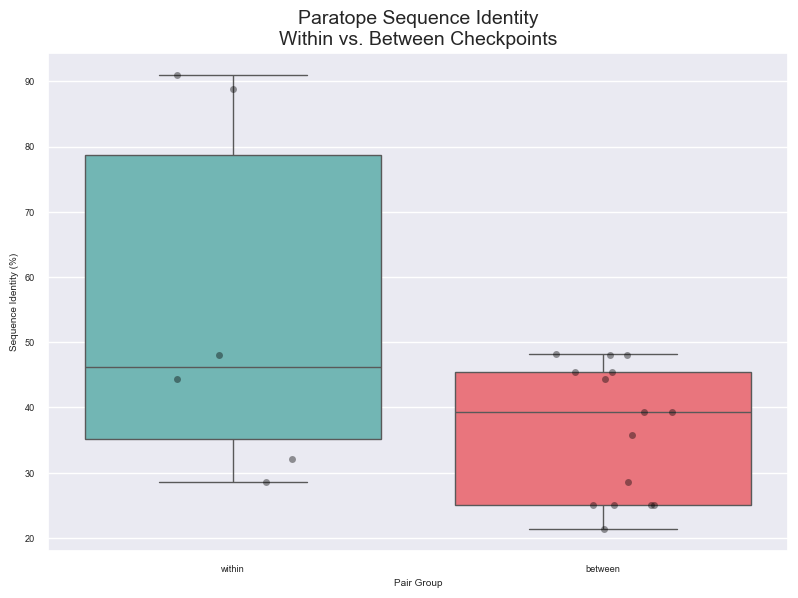

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Falls noch nicht vorhanden: 'same_checkpoint' als bool-Typ sichern
df_pairs["same_checkpoint"] = df_pairs["same_checkpoint"].astype(bool)

# Optional: Ersetze True/False durch beschreibende Labels
df_pairs["group"] = df_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#66c2bf", "#fc626c"])
sns.stripplot(data=df_pairs, x="group", y="identity", color='black', alpha=0.4, jitter=0.2)
plt.title("Paratope Sequence Identity\nWithin vs. Between Checkpoints", fontsize=14)
plt.ylabel("Sequence Identity (%)")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


In [ ]:
all_df

,num_hydrogen_bonds,num_salt_bridges,paratope_area,pdb_id,binding_score,pdb_base,checkpoint
0,0.106796,0.000000,0.618800,6txz,0.166478,6txz,TIM3
1,0.053398,0.000000,0.336553,5tru,0.088670,5tru,CTLA-4
2,0.111650,0.000000,0.769530,5b8c,0.198566,5b8c,PD-1
3,0.097087,0.000000,0.482986,5x8l,0.135432,5x8l,PD-L1
4,0.038835,0.666667,0.198832,7su1,0.321967,7su1,CTLA-4
5,1.000000,1.000000,0.731195,9dq4,0.946239,9dq4,CTLA-4
6,0.067961,0.333333,0.662355,6xkr,0.292989,6xkr,PD-1
7,0.097087,0.000000,0.420264,5xj4,0.122888,5xj4,PD-L1
8,0.043689,0.333333,0.313391,7su0,0.213487,7su0,CTLA-4
9,0.048544,0.333333,0.353904,7wvm,0.223532,7wvm,PD-1


In [ ]:
import pandas as pd

wanted_best_pdbs = ['5xj4', '5x8m', '7bxa', '7cgw', '5b8c', '5ggs', '5jxe', '5x8l',
       '5xxy', '5wt9', '5ggr']

filtered_best_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

print(filtered_best_df)

filtered_best_df.to_csv('filtered_pdbs.csv', index=False)





    num_hydrogen_bonds  num_salt_bridges  paratope_area pdb_id  binding_score  \
2             0.111650          0.000000       0.769530   5b8c       0.198566   
3             0.097087          0.000000       0.482986   5x8l       0.135432   
7             0.097087          0.000000       0.420264   5xj4       0.122888   
12            0.087379          0.000000       0.341770   7bxa       0.103305   
14            0.053398          0.000000       0.513363   5jxe       0.124032   
15            0.111650          0.666667       0.540376   7cgw       0.419402   
17            0.111650          0.000000       0.579777   5x8l       0.160616   
18            0.150485          0.000000       1.000000   5ggs       0.260194   
19            0.126214          0.000000       0.897510   5b8c       0.229987   
20            0.092233          0.000000       0.621742   5x8l       0.161242   
21            0.131068          0.333333       0.641926   5wt9       0.314146   
24            0.101942      

,num_hydrogen_bonds,num_salt_bridges,paratope_area,pdb_id,binding_score,pdb_base,checkpoint
2,0.111650,0.000000,0.769530,5b8c,0.198566,5b8c,PD-1
3,0.097087,0.000000,0.482986,5x8l,0.135432,5x8l,PD-L1
7,0.097087,0.000000,0.420264,5xj4,0.122888,5xj4,PD-L1
12,0.087379,0.000000,0.341770,7bxa,0.103305,7bxa,PD-1
14,0.053398,0.000000,0.513363,5jxe,0.124032,5jxe,PD-1
15,0.111650,0.666667,0.540376,7cgw,0.419402,7cgw,PD-1
17,0.111650,0.000000,0.579777,5x8l,0.160616,5x8l,PD-L1
18,0.150485,0.000000,1.000000,5ggs,0.260194,5ggs,PD-1
19,0.126214,0.000000,0.897510,5b8c,0.229987,5b8c,PD-1
20,0.092233,0.000000,0.621742,5x8l,0.161242,5x8l,PD-L1


In [ ]:

import pandas as pd

wanted_worst_pdbs = ['7wsl', '7wvm', '8gy5', '5grj', '6rp8', '5xj3', '9dq4', '7su0',
       '5tru', '7su1', '9dq3']

filtered_worst_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

print(filtered_worst_df)

filtered_worst_df.to_csv('filtered_pdbs.csv', index=False)

    num_hydrogen_bonds  num_salt_bridges  paratope_area pdb_id  binding_score  \
2             0.111650          0.000000       0.769530   5b8c       0.198566   
3             0.097087          0.000000       0.482986   5x8l       0.135432   
7             0.097087          0.000000       0.420264   5xj4       0.122888   
12            0.087379          0.000000       0.341770   7bxa       0.103305   
14            0.053398          0.000000       0.513363   5jxe       0.124032   
15            0.111650          0.666667       0.540376   7cgw       0.419402   
17            0.111650          0.000000       0.579777   5x8l       0.160616   
18            0.150485          0.000000       1.000000   5ggs       0.260194   
19            0.126214          0.000000       0.897510   5b8c       0.229987   
20            0.092233          0.000000       0.621742   5x8l       0.161242   
21            0.131068          0.333333       0.641926   5wt9       0.314146   
24            0.101942      